If you are interested in graident boosting, here is a good place to start: https://xgboost.readthedocs.io/en/latest/tutorials/model.html

This is a supervised machine learning method.

# Predicting PorPerm

In [83]:
!pip install xgboost --upgrade
!pip install sklearn --upgrade

Requirement already up-to-date: xgboost in /usr/local/lib/python3.6/dist-packages (1.3.3)
Requirement already up-to-date: sklearn in /usr/local/lib/python3.6/dist-packages (0.0)


In [84]:
# If you have installation questions, please reach out

import pandas as pd # data storage
import xgboost      # graident boosting 
import numpy as np  # math and stuff

import seaborn as sns
import scipy.stats as stats

import datetime

import xgboost as xgb
print(xgb.__version__)

import sklearn  
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import median_absolute_error
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import accuracy_score, max_error, mean_squared_error
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt # plotting utility

1.3.3


In [85]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [86]:
df = pd.read_csv('drive/My Drive/1_lewis_research/core_to_wl_merge/Merged_dataset_inner_imputed_12_21_2020.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [87]:
df = df.drop(['Unnamed: 0', 'Unnamed: 0.1', 'LiveTime2','ScanTime2', 'LiveTime1','ScanTime1',
              'ref_num', 'API', 'well_name', 'sample_num' ], axis=1)

print(df.columns.values) # printing all column names

df.describe()

['depth_ft' 'USGS_ID' 'CAL' 'GR' 'DT' 'SP' 'DENS' 'PE' 'RESD' 'PHIN'
 'PHID' 'PE_smooth' 'GR_smooth' 'gz_linear_interp' 'gz_pchip_interp'
 'perm_air_md' 'perm_klink_md' 'He_por' 'horz_perm_md' 'effective_por'
 'por_percent' 'stress_swanson_perm_md' 'sample' 'Na' 'Na Err' 'Mg'
 'Mg Err' 'Al' 'Al Err' 'Si' 'Si Err' 'P' 'P Err' 'S' 'S Err' 'K' 'K Err'
 'Ca' 'Ca Err' 'Ti' 'Ti Err' 'Cr' 'Cr Err' 'Mn' 'Mn Err' 'Fe' 'Fe Err'
 'Co' 'Co Err' 'Ni' 'Ni Err' 'Cu' 'Cu Err' 'Zn' 'Zn Err' 'Ba' 'Ba Err']


,depth_ft,CAL,GR,DT,SP,DENS,PE,RESD,PHIN,PHID,PE_smooth,GR_smooth,gz_linear_interp,gz_pchip_interp,perm_air_md,perm_klink_md,He_por,horz_perm_md,effective_por,por_percent,stress_swanson_perm_md,Na,Na Err,Mg,Mg Err,Al,Al Err,Si,Si Err,P,P Err,S,S Err,K,K Err,Ca,Ca Err,Ti,Ti Err,Cr,Cr Err,Mn,Mn Err,Fe,Fe Err,Co,Co Err,Ni,Ni Err,Cu,Cu Err,Zn,Zn Err,Ba,Ba Err
count,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,508.000000,510.000000,510.000000,25.000000,25.000000,24.000000,24.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.0,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000
mean,5397.863358,0.468406,0.325999,0.430844,0.811259,0.613371,0.351642,1.011018,0.172737,0.172737,0.351702,0.326029,4.913576,4.910244,81.002187,73.797216,14.267039,8.304000,11.808000,8.420833,1.646585,1.132042,0.025387,0.762913,0.011739,3.490170,0.012272,32.981494,0.033185,0.048516,0.001821,0.728955,0.002247,1.675288,0.005710,2.779623,0.005543,0.190546,0.001373,0.005787,0.000116,0.016520,0.000705,1.941109,0.003196,0.001315,0.0,0.004773,0.000100,0.003211,0.000822,0.006309,0.000763,0.090289,0.004689
std,5106.156677,0.191316,0.237404,0.263514,0.162843,0.214604,0.186912,1.503608,0.226664,0.226664,0.178735,0.229901,1.738128,1.751499,173.917355,161.251984,9.365678,3.161814,4.446902,3.050728,3.741652,0.777851,0.004405,0.488501,0.002843,1.415185,0.002607,4.940991,0.002003,0.023636,0.000221,0.795110,0.001252,0.761818,0.001383,2.045850,0.002189,0.088087,0.000297,0.002270,0.000075,0.024982,0.000128,1.472163,0.001193,0.000821,0.0,0.000796,0.000002,0.004429,0.000114,0.004559,0.000100,0.065308,0.000594
min,150.000000,0.000000,0.000000,0.003752,0.000000,0.000000,0.000000,-0.744314,0.000570,0.000570,0.004477,0.000258,1.204296,1.199972,0.001000,0.000000,1.000000,1.900000,5.900000,4.000000,0.000390,0.126200,0.016000,0.047000,0.006800,0.992200,0.007100,8.429500,0.021700,0.000000,0.001100,0.040300,0.000600,0.118400,0.002000,0.133500,0.001400,0.048500,0.000800,0.000000,-0.001200,0.000000,0.000500,0.270700,0.001300,0.000200,0.0,0.002700,0.000100,0.000000,0.000200,0.000000,0.000500,0.000000,0.003100
25%,450.725000,0.360072,0.122318,0.174146,0.743878,0.424460,0.216157,-0.037336,0.004595,0.004595,0.220800,0.131058,3.538724,3.531571,0.040750,0.020250,8.300000,7.900000,8.400000,6.800000,0.001140,0.768500,0.023400,0.293850,0.009100,2.411025,0.010200,29.728050,0.032000,0.032400,0.001700,0.182225,0.001200,1.069725,0.004600,1.103025,0.003600,0.121875,0.001100,0.004400,0.000100,0.003200,0.000600,0.964250,0.002300,0.000700,0.0,0.004300,0.000100,0.000000,0.000700,0.002700,0.000700,0.053200,0.004300
50%,1614.650000,0.554827,0.275825,0.471657,0.867010,0.605516,0.329327,0.795008,0.005532,0.005532,0.337049,0.283192,4.307541,4.256191,0.065500,0.037500,9.300000,9.500000,10.600000,7.300000,0.002070,1.057300,0.025200,0.692000,0.011700,3.133250,0.011700,31.893100,0.033300,0.047250,0.001800,0.461450,0.001900,1.560450,0.005800,2.593250,0.005700,0.160300,0.001300,0.005400,0.000100,0.014200,0.000700,1.658800,0.003100,0.001200,0.0,0.004800,0.000100,0.000000,0.000800,0.005400,0.000800,0.079300,0.004700
75%,9649.575000,0.602566,0.530980,0.662807,0.925012,0.830179,0.470706,1.378387,0.332503,0.332503,0.463317,0.525448,6.615175,6.633493,71.375000,59.675000,26.610000,10.300000,13.800000,9.200000,0.949777,1.322750,0.026700,1.192400,0.014400,4.531475,0.014400,37.944075,0.034700,0.061800,0.002000,0.941100,0.002900,2.291400,0.006900,3.872700,0.007000,0.258025,0.001600,0.006800,0.000100,0.023400,0.000800,2.616775,0.003900,0.001700,0.0,0.005200,0.000100,0.006300,0.000900,0.009200,0.0

In [88]:
df = df[df.He_por >= 0]

In [89]:
df.describe()

,depth_ft,CAL,GR,DT,SP,DENS,PE,RESD,PHIN,PHID,PE_smooth,GR_smooth,gz_linear_interp,gz_pchip_interp,perm_air_md,perm_klink_md,He_por,horz_perm_md,effective_por,por_percent,stress_swanson_perm_md,Na,Na Err,Mg,Mg Err,Al,Al Err,Si,Si Err,P,P Err,S,S Err,K,K Err,Ca,Ca Err,Ti,Ti Err,Cr,Cr Err,Mn,Mn Err,Fe,Fe Err,Co,Co Err,Ni,Ni Err,Cu,Cu Err,Zn,Zn Err,Ba,Ba Err
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,508.000000,510.000000,510.000000,0.0,0.0,0.0,0.0,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.0,278.000000,2.780000e+02,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000
mean,7867.600980,0.382282,0.179142,0.377466,0.778869,0.649789,0.256971,1.495353,0.265479,0.265479,0.257969,0.178263,3.689109,3.682660,81.002187,73.797216,14.267039,NaN,NaN,NaN,NaN,1.235203,0.023721,0.268963,0.008699,2.855647,0.011083,38.274720,0.034292,0.040123,0.001753,0.237229,0.001338,0.997110,0.004357,1.506971,0.003673,0.124190,0.001156,0.005897,0.000138,0.005518,0.000647,0.930934,0.002183,0.000698,0.0,0.004577,1.000000e-04,0.000256,0.000742,0.002947,0.000723,0.096048,0.004566
std,5033.378062,0.205618,0.175484,0.246866,0.169735,0.226908,0.184102,2.004077,0.213216,0.213216,0.175842,0.162409,0.870278,0.882865,173.917355,161.251984,9.365678,NaN,NaN,NaN,NaN,0.555896,0.003559,0.193543,0.001319,0.823285,0.001488,3.392773,0.001691,0.016370,0.000205,0.174879,0.000431,0.439481,0.000859,2.001560,0.001986,0.043739,0.000145,0.002342,0.000058,0.009698,0.000079,0.583494,0.000592,0.000357,0.0,0.000469,4.073090e-19,0.001415,0.000070,0.002076,0.000067,0.071448,0.000438
min,157.200000,0.026503,0.000000,0.026835,0.185083,0.002306,0.000098,-0.731287,0.003645,0.003645,0.004730,0.000285,1.818713,1.803624,0.001000,0.000000,1.000000,NaN,NaN,NaN,NaN,0.409700,0.016000,0.078000,0.007000,1.094000,0.007600,24.356200,0.027700,0.003000,0.001300,0.040300,0.000700,0.265000,0.002500,0.148400,0.001600,0.050000,0.000900,0.000000,-0.000300,0.000000,0.000500,0.272300,0.001300,0.000300,0.0,0.003300,1.000000e-04,0.000000,0.000600,0.000000,0.000500,0.013700,0.003700
25%,875.500000,0.179520,0.054419,0.187125,0.710497,0.433252,0.129545,-0.044952,0.006060,0.006060,0.132651,0.061789,3.211728,3.212229,0.040750,0.020250,8.300000,NaN,NaN,NaN,NaN,1.012700,0.022600,0.150275,0.007900,2.556875,0.010600,37.809275,0.033900,0.029050,0.001600,0.137250,0.001000,0.778200,0.003900,0.502150,0.002500,0.101700,0.001100,0.004400,0.000100,0.000000,0.000600,0.656325,0.001900,0.000500,0.0,0.004300,1.000000e-04,0.000000,0.000700,0.001500,0.000700,0.054200,0.004300
50%,9440.200000,0.413325,0.119408,0.297110,0.830718,0.746584,0.216451,1.054603,0.268676,0.268676,0.216275,0.126171,3.621850,3.620200,0.065500,0.037500,9.300000,NaN,NaN,NaN,NaN,1.310550,0.024150,0.198100,0.008300,2.912600,0.011250,39.436500,0.034700,0.037000,0.001700,0.179600,0.001200,0.989700,0.004400,0.727550,0.003000,0.119350,0.001100,0.005300,0.000100,0.001200,0.000600,0.813300,0.002100,0.000600,0.0,0.004550,1.000000e-04,0.000000,0.000700,0.002500,0.000700,0.073700,0.004500
75%,10295.750000,0.594764,0.241328,0.632071,0.903156,0.837204,0.328656,1.891132,0.430926,0.430926,0.343879,0.248199,3.857325,3.849729,71.375000,59.675000,26.610000,NaN,NaN,NaN,NaN,1.450950,0.025175,0.315550,0.009100,3.129675,0.011700,40.037800,0.035300,0.047100,0.001800,0.284175,0.001500,1.126125,0.004700,1.174350,0.003675,0.138200,0.001200,0.006600,0.000200,0.005650,0.000700,0.989900,0.002300,0.000700,0.0,0.004800,1.000000e-04,0.000000,0.000800,0.003900,0.000700,0.109950,0.004800
max,13584.000000,0.611344,0.911408,0.963093,0.999890,0.954558,0.934521,8.924409,0.998360,0.998360,0.881915,0.826759,7.589500,7.589500,994.000000,936.000000,32

In [90]:
df = df[df.USGS_ID != 'E997']

In [91]:
df.USGS_ID.unique()

array(['E952', 'E945', 'E974', 'F041', 'F042', 'CEPO', 'S179', 'PDRMT'],
      dtype=object)

## Loading in dataset

In [92]:
dataset = df[[
    'depth_ft', 'CAL', 'GR', 'DT', 'SP', 'DENS', 'PE',
       'RESD', 'PHIN', 'PHID', 
       'GR_smooth', 
       'PE_smooth','He_por'
]]

In the next code block, we will remove the rows without data, and change string NaN's to np.nans

In [93]:
dataset.replace('NaN',np.nan, regex=True, inplace=True)# 
#dataset = dataset.dropna()
np.shape(dataset)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


(357, 13)

In [94]:
dataset.head(3)

,depth_ft,CAL,GR,DT,SP,DENS,PE,RESD,PHIN,PHID,GR_smooth,PE_smooth,He_por
1229,10222.3,0.554827,0.106534,0.062840,0.428129,0.640543,0.142615,7.794016,0.443457,0.443457,0.079817,0.168882,8.0
1240,10223.4,0.554827,0.112556,0.056922,0.438185,0.655566,0.218843,7.794016,0.385185,0.385185,0.094562,0.190306,7.9
1250,10224.4,0.554827,0.066613,0.062503,0.451586,0.640814,0.223560,7.066365,0.430617,0.430617,0.102731,0.196158,7.9


In [95]:
X = dataset[['depth_ft', 'CAL', 'GR', 'DT', 'SP', 'DENS', 'PE',
        'RESD', 'PHIN', 'PHID', 
        'GR_smooth', 
        'PE_smooth']]

Y = dataset[['He_por']]

Y_array = np.array(Y.values)

## Starting to set up the ML model params

In [96]:
seed = 7 # random seed is only used if you want to compare exact answers with friends 
test_size = 0.25 # how much data you want to withold, .15 - 0.3 is a good starting point

X_train, X_test, y_train, y_test = train_test_split(X.values, Y_array, test_size=test_size)

### Let's try some hyperparameter tuning (this takes forever!)

Hyperparameter testing does a grid search to find the best parameters, out of the parameters below. This turned out to be really slow on my laptop. Please skip this! 

In [97]:
xg_reg = xgb.XGBRegressor()

xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

rmse = mean_squared_error(y_test, preds, squared=False)
print("Mean Squared Error: %f" % (rmse))
max = max_error(y_test, preds)
print("Max Error: %f" % (max))

MAE = median_absolute_error(y_test, preds)
print("Median Abs Error: %f" % (MAE))

Mean Squared Error: 1.625631
Max Error: 5.926956
Median Abs Error: 0.547055


In [98]:
parameters = {
    'max_depth': range (4, 6, 1),
    'n_estimators': range(20, 55, 5),
    'colsample_bytree': [ 0.9, 1],
    'learning_rate': [ 0.2, 0.1, 0.05],
    'max_delta_step':  [ 0, 1, 2, 4, 8, 16],
    'reg_alpha' : [0, 1, 2, 4]
}

estimator = xgb.XGBRegressor(tree_method='gpu_hist', 
                             gpu_id=0, 
                             objective ='reg:squarederror')

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    n_jobs = 8,
    cv = 5,
    verbose = True
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 2016 candidates, totalling 10080 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    7.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   19.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   35.7s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:   56.2s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:  1.5min
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:  2.2min
[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed:  2.7min
[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed:  3.6min
[Parallel(n_jobs=8)]: Done 4034 tasks      | elapsed:  4.4min
[Parallel(n_jobs=8)]: Done 4984 tasks      | elapsed:  5.4min
[Parallel(n_jobs=8)]: Done 6034 tasks      | elapsed:  6.5min
[Parallel(n_jobs=8)]: Done 7184 tasks      | elapsed:  7.8min
[Parallel(n_jobs=8)]: Done 8434 tasks      | elapsed:  9.1min
[Parallel(n_jobs=8)]: Done 9784 tasks      | elapsed: 10.3min
[Parallel(n_jobs=8)]: Done 10080 out of 10080 | elapsed: 10.6

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None, gpu_id=0,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimator...
                                    subsample=None, tree_method='gpu_hist',
                                    validate_parameters=None, verbosity=None),
             iid='deprecated', n_jobs=8,
             param_grid={'colsample_bytree': [0.9, 1],
                         'learning_rate':

In [99]:
grid_search.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=2, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=40, n_jobs=2, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=4,
             reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='gpu_hist', validate_parameters=1, verbosity=None)

Now plug in the hyperparameters into the training model.

In [100]:
model1 = xgb.XGBRegressor(objective ='reg:squarederror',
                          n_estimators=grid_search.best_estimator_.n_estimators,
                          max_depth = grid_search.best_estimator_.max_depth,
                          learning_rate=grid_search.best_estimator_.learning_rate, 
                          colsample_bytree=grid_search.best_estimator_.colsample_bytree,
                          max_delta_step=grid_search.best_estimator_.max_delta_step,
                          reg_alpha=grid_search.best_estimator_.reg_alpha
                          )

model1.fit(X_train, y_train)

preds2 = model1.predict(X_test)

In [101]:
rmse2 = mean_squared_error(y_test, preds2, squared=False)
print("Mean Squared Error: %f" % (rmse2))

max1 = np.sqrt(max_error(y_test, preds2))
print("Max Error: %f" % (max1))

MAE2 = median_absolute_error(y_test, preds2)
print("Median Abs Error: %f" % (MAE2))

Mean Squared Error: 1.564250
Max Error: 2.389696
Median Abs Error: 0.717265


# write out to dataframe

In [102]:
x = datetime.datetime.now()

d = {'target': [Y.columns.values, Y.columns.values],
     'MSE': [rmse, rmse2],
     'MaxError': [max, max1], 
     'MAE':[MAE, MAE2],
     'day': [x.day, x.day], 
     'month':[x.month, x.month], 
     'year':[x.year, x.year],
     'model':['XGB', 'XGB'],
     'version':[xgb.__version__, xgb.__version__ ]}

results = pd.DataFrame(data=d)

results.to_csv('drive/My Drive/1_lewis_research/analysis/experiments/xgb/results_xgb/he_por_xgb.csv')

results

,target,MSE,MaxError,MAE,day,month,year,model,version
0,[He_por],1.625631,5.926956,0.547055,15,2,2021,XGB,1.3.3
1,[He_por],1.564250,2.389696,0.717265,15,2,2021,XGB,1.3.3


# Plotting

(array([  5.,   2.,   4.,  11.,  16.,  19.,  47., 111.,  47.,   5.]),
 array([ 1.  ,  2.08,  3.16,  4.24,  5.32,  6.4 ,  7.48,  8.56,  9.64,
        10.72, 11.8 ]),
 <a list of 10 Patch objects>)

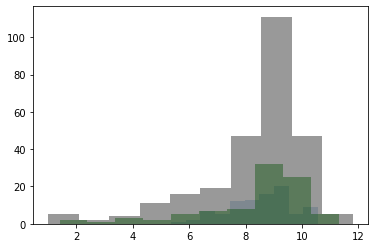

In [103]:
plt.hist(preds, alpha=0.2, bins = 10)
plt.hist(y_test, alpha=0.4, bins=10, color='g')
plt.hist(y_train, alpha=0.4, bins=10, color='black')

In [104]:
print('y_test:', np.median(y_test))
print('pred:', np.median(preds))
print('y_train:', np.median(y_train))

y_test: 9.0
pred: 8.653969
y_train: 8.9


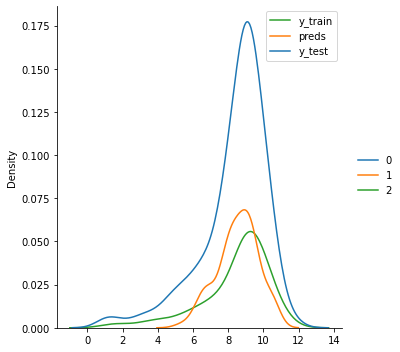

In [105]:
sns.displot([y_train.flatten(), 
             preds.flatten(),
             y_test.flatten()], kind="kde")

plt.legend(['y_train', 'preds', 'y_test'])


(-10.0, 10.0)

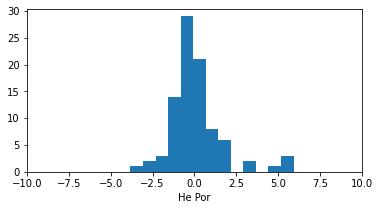

In [106]:
error = preds.flatten() - y_test.flatten()

plt.figure(figsize=(6,3))
plt.hist(error, bins=13)
plt.xlabel('He Por')
plt.xlim((-10,10))

Text(0.5, 0, 'Xgboost Feature Importance')

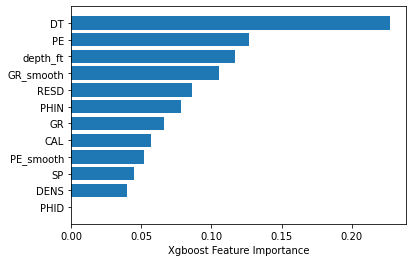

In [107]:
sorted_idx = model1.feature_importances_.argsort()

plt.barh(X.columns[sorted_idx], model1.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")